In [1]:
import pandas as pd
import numpy as np

In [2]:
# load full csv
raw=pd.read_csv("credit_card_transactions.csv")
# columns present in the CSV file
all_cols = [
    "Unnamed: 0","trans_date_trans_time","cc_num","merchant","category","amt",
    "first","last","gender","street","city","state","zip","lat","long","city_pop",
    "job","dob","trans_num","unix_time","merch_lat","merch_long","is_fraud","merch_zipcode"
]

# keep only the columns needed for the baseline:
#    - timestamp: to derive temporal signals (day_of_week, hour)
#    - merchant: main text signal for category classification via TF-IDF
#    - category: label (target) for supervised learning
#    - amount: numeric magnitude; to derive log_amount and amount_bin
#    - city, state(optional, but it is considered in this project)

keep_map = {
    "trans_date_trans_time": "timestamp",
    "merchant": "merchant",
    "category": "category",
    "amt": "amount",
    "city": "city",
    "state": "state",
}

# selecting req columns and renaming them
df = raw[list(keep_map.keys())].rename(columns=keep_map)

# 2) Drop rows with essential missing values
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df["merchant"] = df["merchant"].fillna("").str.lower().str.replace(r"[^\w\s]", " ", regex=True).str.strip()


# if there is any NaT or NaN generated from the above code, then drop those rows
df=df.dropna(subset=["timestamp","amount","category"]).reset_index(drop=True)

print("Final columns: ",df.columns.tolist())
print("shape after selection: ",df.shape)


Final columns:  ['timestamp', 'merchant', 'category', 'amount', 'city', 'state']
shape after selection:  (1296675, 6)


In [3]:
# Quick sanity checks
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)

print("\nNull counts:\n", df.isna().sum())

# Show a few rows
display(df.head(10))

# Basic label distribution
cat_counts = df["category"].value_counts(dropna=False)
print("\nCategory counts (top 20):\n", cat_counts.head(20))
print("Num categories:", df["category"].nunique())

# Amount sanity
print("\nAmount summary:\n", df["amount"].describe())
num_nonpos = (df["amount"] <= 0).sum()
print("Non-positive amounts:", num_nonpos)

# Timestamp sanity
num_invalid_time = df["timestamp"].isna().sum()
print("Invalid/NaT timestamps:", num_invalid_time)

# Optional: exact duplicate rows after column selection
dup_rows = df.duplicated().sum()
print("Exact duplicate rows:", dup_rows)


Shape: (1296675, 6)

Dtypes:
 timestamp    datetime64[ns]
merchant             object
category             object
amount              float64
city                 object
state                object
dtype: object

Null counts:
 timestamp    0
merchant     0
category     0
amount       0
city         0
state        0
dtype: int64


,timestamp,merchant,category,amount,city,state
0,2019-01-01 00:00:18,fraud_rippin kub and mann,misc_net,4.97,Moravian Falls,NC
1,2019-01-01 00:00:44,fraud_heller gutmann and zieme,grocery_pos,107.23,Orient,WA
2,2019-01-01 00:00:51,fraud_lind buckridge,entertainment,220.11,Malad City,ID
3,2019-01-01 00:01:16,fraud_kutch hermiston and farrell,gas_transport,45.00,Boulder,MT
4,2019-01-01 00:03:06,fraud_keeling crist,misc_pos,41.96,Doe Hill,VA
5,2019-01-01 00:04:08,fraud_stroman hudson and erdman,gas_transport,94.63,Dublin,PA
6,2019-01-01 00:04:42,fraud_rowe vandervort,grocery_net,44.54,Holcomb,KS
7,2019-01-01 00:05:08,fraud_corwin collins,gas_transport,71.65,Edinburg,VA
8,2019-01-01 00:05:18,fraud_herzog ltd,misc_pos,4.27,Manor,PA
9,2019-01-01 00:06:01,fraud_schoen kuphal and nitzsche,grocery_pos,198.39,Clarksville,TN



Category counts (top 20):
 category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64
Num categories: 14

Amount summary:
 count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amount, dtype: float64
Non-positive amounts: 0
Invalid/NaT timestamps: 0
Exact duplicate rows: 0


In [4]:
# Feature engineering
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["hour"] = df["timestamp"].dt.hour
df["month"] = df["timestamp"].dt.to_period("M").astype(str)  # for insights/plots
df["log_amount"] = np.log1p(df["amount"])
df["amount_bin"] = pd.qcut(df["amount"], q=5, labels=False, duplicates="drop")

use_state = False

In [9]:
from sklearn.model_selection import train_test_split

use_sample = True   # set False to use full df
sample_size = 300_000  # adjust based on runtime limits

if use_sample:
    _, df_work = train_test_split(
        df, test_size=min(sample_size, len(df)), stratify=df["category"], random_state=42
    )
else:
    df_work = df

print("Working set shape:", df_work.shape)


Working set shape: (300000, 11)


In [6]:
print(df_work.head())

                 timestamp                             merchant  \
287173 2019-05-21 00:53:34             fraud_stoltenberg beatty   
250371 2019-05-05 10:24:33  fraud_eichmann  bogan and rodriguez   
194896 2019-04-10 16:56:24  fraud_schmeler  bashirian and price   
811933 2019-12-07 11:39:23                    fraud_beier hyatt   
777981 2019-11-29 19:14:29                   fraud_ernser feest   

             category  amount          city state  day_of_week  hour    month  \
287173   shopping_pos    7.79        Aurora    CO            1     0  2019-05   
250371  gas_transport   82.73      Damascus    VA            6    10  2019-05   
194896   shopping_net   23.74      Bessemer    AL            2    16  2019-04   
811933   shopping_pos  147.51        Hewitt    WI            5    11  2019-12   
777981           home   24.71  Pewee Valley    KY            4    19  2019-11   

        log_amount  amount_bin  
287173    2.173615           1  
250371    4.427597           3  
194896    3

**Train, Evaluate, and Save Model**

     - Build a reproducible pipeline: TF‑IDF on merchant text + passthrough numeric features → LogisticRegression.

     - Use a stratified train/validation split to preserve class balance.

     - Evaluate with macro and weighted F1, print per‑class report, and plot the confusion matrix.

     - Save versioned artifacts for deployment and review:

         - models/pipeline_v2_300k.joblib

         - outputs/metrics_v2_300k.json

         - outputs/confusion_matrix_v2_300k.png

         - outputs/predictions_sample.csv

***Settings***

     - Features: merchant TF‑IDF + [log_amount, amount_bin, day_of_week, hour]

     - TF‑IDF: ngram_range=(1,1), max_features=10,000, min_df=3

     - Classifier: LogisticRegression(class_weight="balanced", solver="lbfgs", C=0.7, max_iter=900)

     - Split: test_size=0.2, stratify=category, random_state=42

***Notes***

     - If a convergence warning appears, increase max_iter or switch solver to "saga".

     - Keep these settings consistent in any downstream app that loads the serialized pipeline.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro F1: 0.9914
Weighted F1: 0.9921

Classification report:
                 precision    recall  f1-score   support

 entertainment       0.99      0.99      0.99      4350
   food_dining       1.00      1.00      1.00      4232
 gas_transport       1.00      1.00      1.00      6092
   grocery_net       1.00      1.00      1.00      2103
   grocery_pos       0.99      1.00      1.00      5721
health_fitness       0.98      0.99      0.98      3974
          home       1.00      1.00      1.00      5697
     kids_pets       1.00      1.00      1.00      5230
      misc_net       0.99      0.99      0.99      2928
      misc_pos       0.98      0.97      0.98      3686
 personal_care       0.99      0.99      0.99      4200
  shopping_net       0.98      0.98      0.98      4514
  shopping_pos       1.00      0.99      0.99      5399
        travel       0.98      0.99      0.99      1874

      accuracy                           0.99     60000
     macro avg       0.99      0.99     

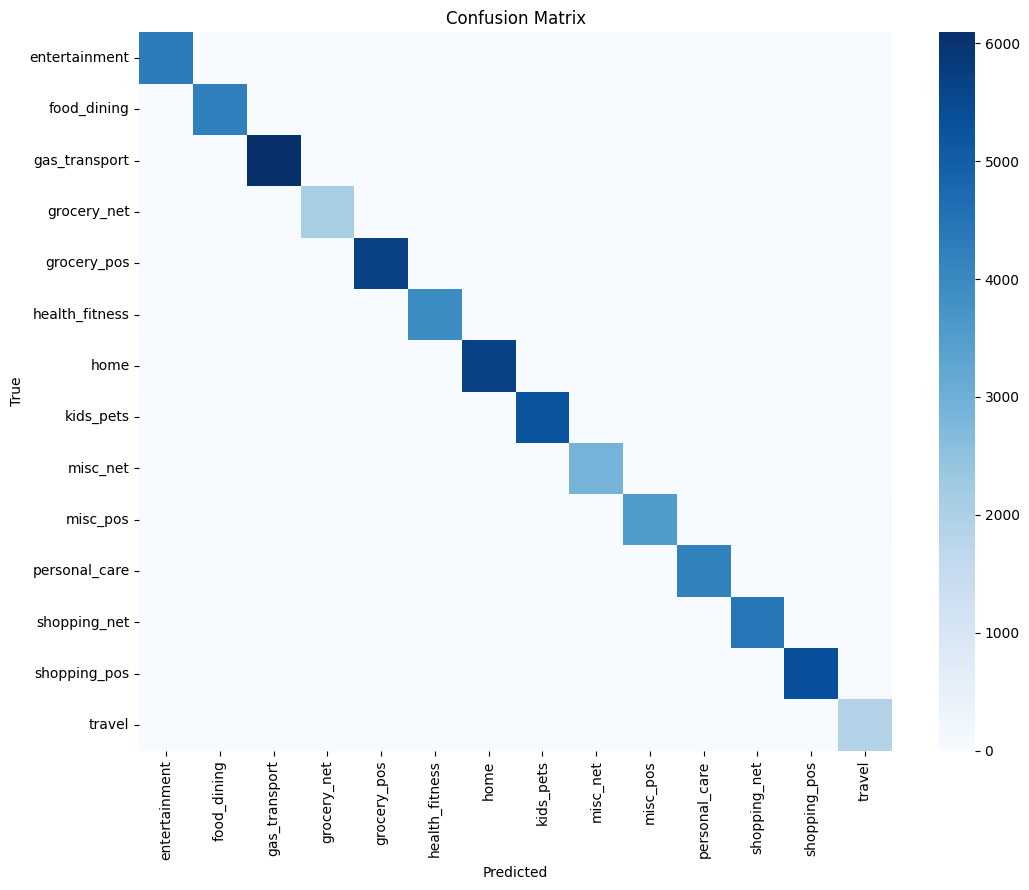

In [11]:
# TRAINING: build pipeline, fit, evaluate, and print a compact summary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, json
import joblib

# Config
text_col = "merchant"
num_cols = ["log_amount","amount_bin","day_of_week","hour"]
use_state = False
cat_cols = ["state"] if use_state and ("state" in df_work.columns) else []

# Data split
X = df_work.copy()
y = df_work["category"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessor
# TF-IDF lean for speed and convergence
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=10000, min_df=3)

transformers = [
    ("tfidf", tfidf, text_col),
    ("num", "passthrough", num_cols),
]
if cat_cols:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols))

preproc = ColumnTransformer(
    transformers,
    remainder="drop",
    verbose_feature_names_out=False
)

# Classifier
# Remove deprecated multi_class arg; increase iterations; modest regularization
clf = LogisticRegression(
    class_weight="balanced",
    max_iter=900, #more iters for 300k rows of training, initially it was 700 for 100k rows
    C=0.7,
    solver="lbfgs",
)

# Pipeline
pipe = Pipeline([
    ("preproc", preproc),
    ("clf", clf),
])

# Fit
pipe.fit(X_train, y_train)

# Evaluate
y_pred = pipe.predict(X_val)
macro_f1 = f1_score(y_val, y_pred, average="macro")
weighted_f1 = f1_score(y_val, y_pred, average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print("\nClassification report:\n", classification_report(y_val, y_pred))

labels = sorted(y_val.unique())
cm = confusion_matrix(y_val, y_pred, labels=labels)
plt.figure(figsize=(11,9))
sns.heatmap(cm, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#  Save artifacts
os.makedirs("outputs", exist_ok=True)
os.makedirs("models", exist_ok=True)

with open("outputs/metrics_v2_300k.json", "w") as f:
    json.dump({"macro_f1": float(macro_f1), "weighted_f1": float(weighted_f1)}, f, indent=2)

plt.figure(figsize=(11,9))
sns.heatmap(cm, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix(300K)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("outputs/confusion_matrix_v2_300k.png", dpi=150)
plt.close()

joblib.dump(pipe, "models/pipeline_v2_300k.joblib")

# Small prediction sample for inspection
errs = X_val.copy()
errs["true"] = y_val.values
errs["pred"] = y_pred
errs.head(200)[["merchant","amount","timestamp","true","pred"]].to_csv(
    "outputs/predictions_sample.csv", index=False
)


